# Part 1A: Sale Prediction via Basis Regression

### Least Squares via Normal Equations, QR Decomposition & SVD

In [1]:
def lstsq_norm_e(A, b):
    L = np.linalg.cholesky(np.dot(A.T, A))
    R = L.T
    A_tb = np.dot(A.T, b)
    w = np.linalg.solve(R.T, A_tb)
    return np.linalg.solve(R, w)


def lstsq_qr(A, b):
    Q, R = np.linalg.qr(A, mode='reduced')
    Qtb = np.dot(Q.T, b)
    return np.linalg.solve(R, Qtb)


def lstsq_svd(A, b):
    U,S,V = np.linalg.svd(A,full_matrices=False)
    V = V.T
    U_tb = np.dot(U.T,b)
    S = np.diag(S)
    w = np.linalg.solve(S, U_tb)
    return np.dot(V,w)

### Helper Functions

In [2]:
def p11_form_A(months):
    N = months.shape[0]
    A = np.zeros([N,8])
    for i in range(N):
        pi = np.pi
        row = np.array([np.sin(pi * (1.0/12) * months[i]), np.cos(pi * (1.0/12) * months[i]),
                np.sin(pi * (1.0/6) * months[i]), np.cos(pi * (1.0/6) * months[i]),
                np.sin(pi * (1.0/2) * months[i]), np.cos(pi * (1.0/2) * months[i]),
                months[i],
                1])
        A[i,:] = row
    return A


def p11_remove_nans(row_vector):
    months = np.nonzero(~np.isnan(row_vector))[0]
    sales = row_vector[months]
    return months, sales

### 1. Estimate Sales of Next 6 Months

In [3]:
# 1: Estimate
def p11_basis_regression_all_items(sales_data):
    num_item = sales_data.shape[0]
    sales = np.zeros([num_item, 3, 6])  # which item, which method, which month?
    months = np.zeros([num_item, 6])
    for i in range(num_item):
        months_current_item, sales_current_item = p11_remove_nans(sales_data[i, :])
        future_months, future_sales = p11_basis_regression_one_item(months_current_item, sales_current_item)
        print 'Item %d Predictions' % i
        print future_sales, '\n'
        sales[i] = future_sales
        months[i] = future_months
    return months, sales


def p11_basis_regression_one_item(months, sales):
    A = p11_form_A(months)
    b = sales

    x_norm_e = lstsq_norm_e(A,b)
    x_qr = lstsq_qr(A,b)
    x_svd = lstsq_svd(A,b)

    next_six_months = np.arange(months[-1]+1, months[-1]+7)
    A_new = p11_form_A(next_six_months)

    next_six_sales = np.zeros([3,6])  # 3 methods, 6 months estimated

    next_six_sales[0,:] = np.dot(A_new, x_norm_e)
    next_six_sales[1,:] = np.dot(A_new, x_qr)
    next_six_sales[2,:] = np.dot(A_new, x_svd)
    return next_six_months, next_six_sales

### 2. Compare Different Methods

In [4]:
def p11_compare_methods_all_items(sales_estimated):
    num_item = sales_estimated.shape[0]
    comparison = np.zeros([num_item, 3, 3])  # which item, which method, compared to which method?
    for i in range(num_item):
        comparison_one_item = p11_compare_methods_one_item(sales_estimated[i, :, :])
        print 'Item %d Comparison of Methods' % i
        print comparison_one_item, '\n'
        comparison[i,:,:] = comparison_one_item
    return comparison


def p11_compare_methods_one_item(sales_estimated_for_item):  # (3,6) matrix
    relative_error = np.zeros([3,3])
    for i in range(3):
        for j in range(3):
            x = sales_estimated_for_item[i,:]
            y = sales_estimated_for_item[j,:]
            nom = np.linalg.norm(x - y)
            denom = np.linalg.norm(y)
            relative_error[i,j] = nom / denom
    return relative_error

### 3. Find Error Compared to Ground Truth

In [5]:
def p11_gt_all_items(sales_estimated, test_data):
    num_item = sales_estimated.shape[0]
    gt_error = np.zeros([num_item, 3])  # which item, which method?
    for i in range(num_item):
        gt_error_one_item = p11_gt_one_item(sales_estimated[i, :], test_data[i, :])
        print 'Item %d Error compared to Groud Truth' % i
        print gt_error_one_item, '\n'
        gt_error[i,:] = gt_error_one_item
    return gt_error


def p11_gt_one_item(sales_estimated_for_item, test_data_for_item):  # (3,6) matrix
    e = np.linalg.norm(sales_estimated_for_item - test_data_for_item, axis=1)
    return e

### Call 3 Procedures Above, Plot

In [14]:
def basis_regression(sales_data, test_data=None):
    future_months, future_sales = p11_basis_regression_all_items(sales_data)
    method_comparison = p11_compare_methods_all_items(future_sales)
    gt_errors = None
    if test_data is not None:
        gt_errors = p11_gt_all_items(future_sales, test_data)
    return future_months, future_sales, method_comparison, gt_errors


def project_part1_1(train, test=None):
    future_months, future_sales, comparison, gt_error = basis_regression(train, test)

    plt.figure(figsize=(16, 8))
    colors = ['r','k','g','b','m','y','c']
    for i in range(train.shape[0]):
        past_months, past_sales = p11_remove_nans(train[i, :])
        plt.plot(past_months, past_sales, '--o', color=colors[i], lw=0.7, ms=6)
        plt.plot(future_months[i,:], future_sales[i,0,:], '^', color=colors[i], ms=8)
    plt.show()

    errors = None
    if test is not None:
        errors = test - future_sales[:,0,:]

    return future_months, future_sales, errors

### Test 1: Dataset without NaN's

Item 0 Predictions
[[ 383.07  386.7   404.29  392.67  360.95  354.16]
 [ 383.07  386.7   404.29  392.67  360.95  354.16]
 [ 383.07  386.7   404.29  392.67  360.95  354.16]] 

Item 1 Predictions
[[ 575.82  559.44  582.84  592.78  567.52  561.97]
 [ 575.82  559.44  582.84  592.78  567.52  561.97]
 [ 575.82  559.44  582.84  592.78  567.52  561.97]] 

Item 2 Predictions
[[ 1107.66  1067.86  1058.43  1071.17  1043.56   990.5 ]
 [ 1107.66  1067.86  1058.43  1071.17  1043.56   990.5 ]
 [ 1107.66  1067.86  1058.43  1071.17  1043.56   990.5 ]] 

Item 3 Predictions
[[ 650.92  633.07  630.49  631.68  622.16  620.8 ]
 [ 650.92  633.07  630.49  631.68  622.16  620.8 ]
 [ 650.92  633.07  630.49  631.68  622.16  620.8 ]] 

Item 4 Predictions
[[ 1008.84   997.1   1029.69  1026.92   974.4    957.51]
 [ 1008.84   997.1   1029.69  1026.92   974.4    957.51]
 [ 1008.84   997.1   1029.69  1026.92   974.4    957.51]] 

Item 0 Comparison of Methods
[[  0.00e+00   5.94e-14   6.19e-14]
 [  5.94e-14   0.00e+00 

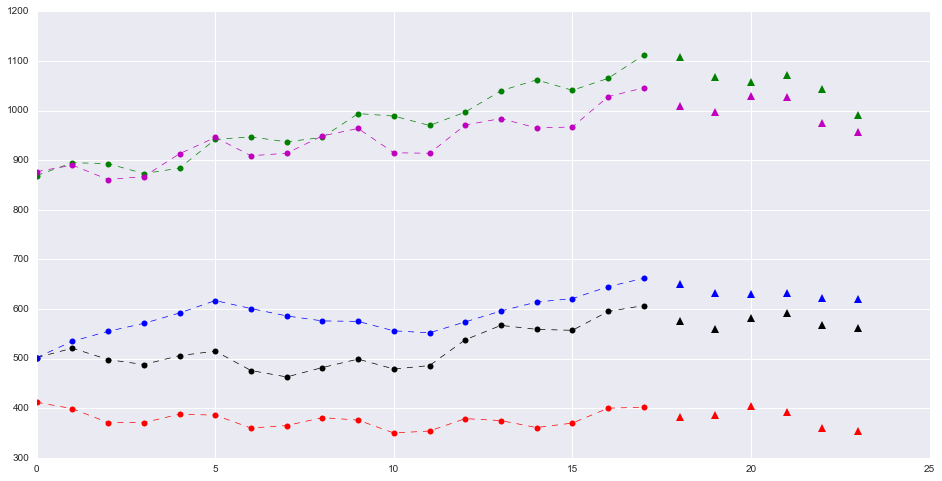

Errors : 
[[  2.93  11.3   15.71  19.33  23.05  30.84]
 [ -0.82   8.56  13.16  20.22  23.48  33.03]
 [ 10.34  26.14  29.57  40.83  51.44  63.5 ]
 [  6.08  18.93  23.51  33.32  45.84  61.2 ]
 [  4.16  21.9   28.31  35.08  41.6   56.49]]


In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(12345)
np.set_printoptions(precision=2,suppress=False)

R_true = np.genfromtxt('dataset11.csv', delimiter=',',dtype=float)
#train = R_true.copy()
#test = None
train = R_true[:,:18].copy()
test = R_true[:,18:].copy()

future_months, future_sales, errors = project_part1_1(train, test)

print 'Errors : \n', errors

### Test 2: Dataset with NaN's

Item 0 Predictions
[[ 1055.58  1088.39  1088.35  1067.2   1087.94  1135.92]
 [ 1055.58  1088.39  1088.35  1067.2   1087.94  1135.92]
 [ 1055.58  1088.39  1088.35  1067.2   1087.94  1135.92]] 

Item 1 Predictions
[[ 714.21  751.31  772.22  790.35  816.14  829.59]
 [ 714.21  751.31  772.22  790.35  816.14  829.59]
 [ 714.21  751.31  772.22  790.35  816.14  829.59]] 

Item 2 Predictions
[[ 399.14  387.29  359.63  360.02  378.63  371.55]
 [ 399.14  387.29  359.63  360.02  378.63  371.55]
 [ 399.14  387.29  359.63  360.02  378.63  371.55]] 

Item 3 Predictions
[[ 633.52  653.65  631.04  620.95  644.22  645.99]
 [ 633.52  653.65  631.04  620.95  644.22  645.99]
 [ 633.52  653.65  631.04  620.95  644.22  645.99]] 

Item 4 Predictions
[[ 1057.01  1072.63  1042.51  1048.69  1104.3   1123.99]
 [ 1057.01  1072.63  1042.51  1048.69  1104.3   1123.99]
 [ 1057.01  1072.63  1042.51  1048.69  1104.3   1123.99]] 

Item 0 Comparison of Methods
[[  0.00e+00   2.56e-16   1.50e-15]
 [  2.56e-16   0.00e+00 

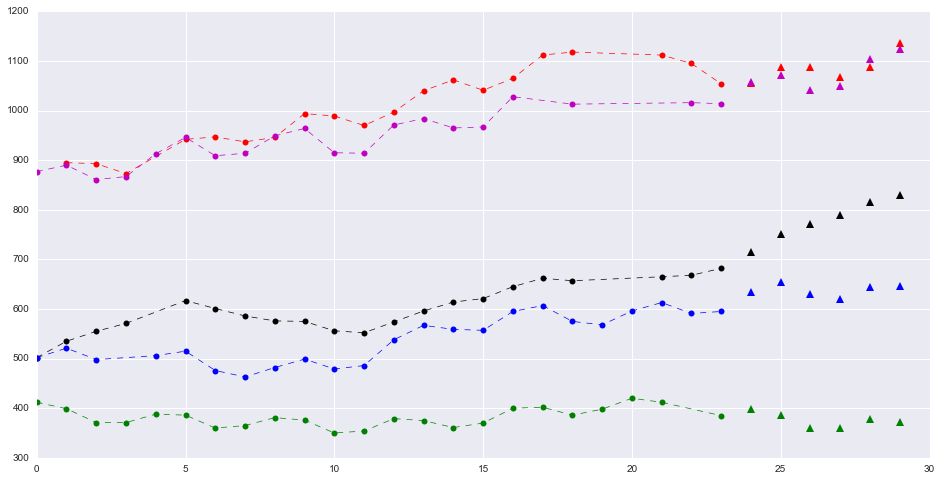

Errors : 
None


In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(12345)
np.set_printoptions(precision=2,suppress=False)

R_true = np.genfromtxt('dataset12.csv', delimiter=',',dtype=float)
train = R_true.copy()
test = None
#train = R_true[:,:18].copy()
#test = R_true[:,18:].copy()

future_months, future_sales, errors = project_part1_1(train, test)

print 'Errors : \n', errors